# Experiment about preprocessing

- fft?

# Prepare ENV/Load libraries

## Mount Google Drive

In [1]:
import os
from google.colab import drive

drive.mount('/content/gdrive')
google_drive_path = "/content/gdrive/MyDrive/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# change directory to the project path

project_path = os.path.join(google_drive_path, "Colab Notebooks/SER/")
os.chdir(project_path)
os.listdir("./")

['utils',
 'fonts',
 'meta_data',
 'dataset',
 '.git',
 '.env',
 'libs',
 'README.md',
 'models',
 '.gitignore',
 'logs',
 'SER Model idea.drawio',
 'deprecated',
 'Preprocess Json to CSV.ipynb',
 'Data distribution.ipynb',
 'Notebook Template.ipynb',
 'Notebook Template Train.ipynb',
 'Untitled0.ipynb',
 'Experiment Preprocessing.ipynb',
 'setting.json']

## Install libraries

In [3]:
# !rm -rf tmp && git clone https://github.com/chuan-khuna/my-python-utils.git tmp && cp -R tmp/utils ./ && cp -R tmp/fonts ./ && rm -rf tmp

In [4]:
!python3 --version

Python 3.8.16


Install latest tensorflow version

In [5]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn8 is already the newest version (8.1.0.77-1+cuda11.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf2onnx 1.13.0 requires flatbuffers<3.0,>=1.12, but you have flatbuffers 22.12.6 which is incompatible.
onnx 1.13.0 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.


In [6]:
!pip install matplotlib seaborn -Uq
!pip install pythainlp -q
!pip install keras-tuner -q
!pip install pyYAML -q
!pip install tensorflow-io[tensorflow] tf2onnx onnxruntime -Uq

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.11.0 requires tensorflow<2.12,>=2.11.0; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.9.0 which is incompatible.


In [7]:
%load_ext tensorboard

# Import Libraries

In [8]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import patheffects
import seaborn as sns

import json
import yaml
import re
from tqdm.notebook import trange, tqdm

import datetime

import tf2onnx
import onnx
import onnxruntime as rt

In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds
import keras_tuner
import tensorflow_io as tfio

seed_ = 20200218
tf.random.set_seed(seed_)
np.random.seed(seed_)

from sklearn.metrics import confusion_matrix, classification_report

In [10]:
from utils.vis_utils import *

font_dir = [f"{google_drive_path}/code_assets/fonts/"]
mpl_import_fonts(font_dir)

## Ensure that matplotlib can use subplot mosaic

In [11]:
def check_version(version_str, major, minor):
    print(version_str)
    version = [int(i) for i in version_str.split('.')]
    assert version[0] >= major and version[1] >= minor

check_version(matplotlib.__version__, 3, 6)
check_version(sns.__version__, 0, 12)

del check_version

matplotlib.__version__, sns.__version__, tf.__version__

3.6.2
0.12.2


('3.6.2', '0.12.2', '2.9.0')

## View hardware spec

In [12]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [13]:
tf.config.list_physical_devices('GPU')

for device in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(device, True)

In [14]:
def get_timestamp():
    return datetime.datetime.strftime(datetime.datetime.now(), "%Y%m%d-%H%M")

get_timestamp()

'20230101-0539'

# Load Dataset

Copy dataset from Google Drive to VM storage

In [15]:
# !rm -rf /content/dataset/

In [16]:
def unzip_dataset(zipfile, target_loc):
    """Unzip a zip file from google drive to VM storage

    I hypothesise that Google Drive has some limits to read files.
    So I decided to extract file to VM storage instead

    ```python
    target_loc = dataset_path = "/content/dataset/"
    ```

    Args:
        zipfile (str): _description_
        target_loc (str): target root folder to place content in the zip file.
    """

    # create root path to store the dataset
    if not os.path.exists(target_loc):
        os.makedirs(target_loc, exist_ok=True)

    subfolder = zipfile.split('/')[-1].split('.zip')[0]
    target_path = os.path.join(target_loc, subfolder)
    print(f"Unzip {zipfile} to {target_path}")
    os.system(f"unzip {zipfile} -d {target_path}")

path_to_zipfiles = "./dataset/"
dataset_path = "/content/dataset/"

if not(os.path.exists(dataset_path) and len(os.listdir(dataset_path)) == 10):
    for filename in os.listdir(path_to_zipfiles):
        if filename.endswith(".zip"):
            zip_path = os.path.join(path_to_zipfiles, filename)
            unzip_dataset(zip_path, dataset_path)

print(os.listdir(dataset_path))

['studio11-20', 'studio41-50', 'studio1-10', 'zoom1-10', 'zoom11-20', 'studio51-60', 'studio71-80', 'studio61-70', 'studio31-40', 'studio21-30']


In [17]:
df = pd.read_csv("./meta_data/dataset.csv")

# drop emotion label that tagged as None
df = df[df['majority_emo'] != 'None']
df = df[df['majority_emo'] != 'other']

# drop corrupted files
df = df[df['duration'] > 0]

df = df[df['agreement'] >= 0.5]

# shuffle
df = df.sample(frac=1)

In [18]:
assert (df['duration'] > 0).all()
df['majority_emo'].drop_duplicates()

10460    Frustrated
5293          Angry
27635       Neutral
24610         Happy
3849            Sad
Name: majority_emo, dtype: object

In [19]:
df

,path,file,assigned_emo,majority_emo,agreement,duration
10460,/content/dataset/zoom1-10/zoom007/mic/z007_mic...,z007_mic_actor049_impro4_4.flac,Angry,Frustrated,1.000000,13.984
26154,/content/dataset/studio21-30/studio022/con/s02...,s022_con_actor079_impro8_13.flac,Frustrated,Frustrated,0.600000,4.776
5293,/content/dataset/studio41-50/studio050/con/s05...,s050_con_actor140_impro10_6.flac,Angry,Angry,1.000000,4.776
3128,/content/dataset/studio41-50/studio049/con/s04...,s049_con_actor138_script3_1_2a.flac,Angry,Frustrated,0.600000,5.283
27635,/content/dataset/studio21-30/studio025/con/s02...,s025_con_actor090_impro6_16.flac,Happy,Neutral,1.000000,0.826
...,...,...,...,...,...,...
5424,/content/dataset/studio41-50/studio050/con/s05...,s050_con_actor139_impro8_13.flac,Frustrated,Frustrated,0.916667,9.052
19068,/content/dataset/studio71-80/studio076/con/s07...,s076_con_actor191_impro14_1.flac,Angry,Angry,0.812500,7.346
1432,/content/dataset/studio11-20/studio016/con/s01...,s016_con_actor032_impro1_23.flac,Angry,Angry,1.000000,5.410
10822,/content/dataset/zoom1-10/zoom006/mic/z006_mic...,z006_mic_actor047_impro1_18.flac,Neutral,Neutral,0.800000,1.306


In [20]:
def plot_wave(tensor):
    fig = plt.figure(figsize=(8, 3), dpi=80)

    length = tf.shape(tensor).numpy()[0]
    if length > 32000:
        length = 32000

    sns.lineplot(tensor.numpy()[:length], linewidth=0.5)
    plt.ylim([-1, 1])
    plt.show()

def plot_spec(tensor, transpose=True):
    fig = plt.figure(figsize=(8, 3), dpi=80)
    
    arr = tensor.numpy()
    if transpose:
        arr = arr.T

    length = arr.shape[1]
    if length > 256:
        length = 256

    sns.heatmap(arr[:, :length], vmin=-40, vmax=40)
    plt.show()

In [21]:
import json
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np


class AudioPreprocessor:

    def __init__(self):
        self.sampling_rate = 16000

        # spectrorgram setting
        self.nfft = 512
        self.window = 512
        self.stride = 256

        # spectrogram to melspectrogram setting
        self.n_mels = 128
        self.max_db = 80

        # padding/truncating (sec)
        self.pad_length = 30

    def from_json(self, file: str):
        with open(file, "r") as f:
            setting = json.load(f)

        for k in self.__dict__.keys():
            self.__dict__[k] = setting[k]

    def save_setting(self, file: str):
        with open(file, "w") as f:
            f.write(json.dumps(self.__dict__, indent=2))

    def _resampling(self, audio_tensor: tf.Tensor, rate: int) -> tf.Tensor:
        """resampling audio tensor from the original sampling rate `rate` to `self.sampling_rate`

        Args:
            audio_tensor (tf.Tensor): audio tensor in shape `(length, )`
            rate (int): sampling rate of the original audio

        Returns:
            tf.Tensor: resampled audio tensor in shape `(length, )`
        """
        if (self.sampling_rate != rate) and (self.sampling_rate is not None):
            audio_tensor = tfio.audio.resample(audio_tensor, rate, self.sampling_rate)
        return audio_tensor

    def _normalise(self, audio_tensor: tf.Tensor) -> tf.Tensor:
        """Normalise audio tensor by dividing the max value of int16 `32768.0`

        Args:
            audio_tensor (tf.Tensor): audio tensor in shape `(length, )`

        Returns:
            tf.Tensor: audio tensor in shape `(length, )`
        """
        # https://www.tensorflow.org/io/tutorials/audio
        # https://keras.io/examples/audio/transformer_asr/#preprocess-the-dataset
        audio_tensor = tf.cast(audio_tensor, tf.float32) / tf.cast(tf.int16.max + 1,
                                                                   dtype=tf.float32)
        return audio_tensor

    def _pad_signal(self, audio_tensor: tf.Tensor) -> tf.Tensor:
        audio_tensor = tf.keras.utils.pad_sequences(audio_tensor[tf.newaxis, :],
                                                    maxlen=self.length * self.sampling_rate,
                                                    dtype='float32',
                                                    padding='post')
        return tf.squeeze(audio_tensor)

    def _to_spectrogram(self, audio_tensor: tf.Tensor) -> tf.Tensor:
        """Convert audio wave tensor to spectrogram tensor

        Args:
            audio_tensor (tf.Tensor): audio tensor in shape `(length, )`

        Returns:
            tf.Tensor: spectrogram tensor in shape `(spec length, features)
        """
        spectogram_tensor = tfio.audio.spectrogram(audio_tensor,
                                                   nfft=self.nfft,
                                                   window=self.window,
                                                   stride=self.stride)
        return spectogram_tensor

    def _spectrogram_to_melspectrogram(self, spectogram_tensor: tf.Tensor) -> tf.Tensor:
        """convert spectrogram to mel-spectrogram

        Args:
            spectogram_tensor (tf.Tensor): tensor in shape `(spec length, features)`

        Returns:
            tf.Tensor: tensor in shape `(spec length, features)`
        """
        melspec_tensor = tfio.audio.melscale(spectogram_tensor,
                                             rate=self.sampling_rate,
                                             mels=self.n_mels,
                                             fmin=0,
                                             fmax=int(self.sampling_rate // 2))
        return melspec_tensor

    def _melspec_to_db_melspec(self, melspec_tensor: tf.Tensor) -> tf.Tensor:
        return tfio.audio.dbscale(melspec_tensor, top_db=self.max_db)

    def _process_audio_tensor_to_melspectrogram(self, audio_tensor: tf.Tensor) -> tf.Tensor:
        """A wrapper function to process audio wave to mel-spectrogram(db scale)

        Args:
            audio_tensor (tf.Tensor): audio tensor in shape `(length, )`

        Returns:
            tf.Tensor: spectrogram tensor in shape `(spec length, features)
        """
        spec = self._to_spectrogram(audio_tensor)
        mel_spec = self._spectrogram_to_melspectrogram(spec)
        mel_spec_db = self._melspec_to_db_melspec(mel_spec)
        return mel_spec_db

    def _audio_tensor_from_file(self, filename: str) -> tf.Tensor:
        """Load audio wave from `.flac` file

        Args:
            filename (str): _description_

        Returns:
            tf.Tensor: tensor in shape `(length, )`
        """

        content = tfio.IOTensor.graph(tf.int16).from_audio(filename)
        rate = content.rate.numpy()
        audio_tensor = content.to_tensor()
        audio_tensor = tf.squeeze(audio_tensor[:, 0])
        return audio_tensor, rate

    def preprocess(self, filename: str) -> tf.Tensor:
        """Preprocess an audio file

        Args:
            filename (str): _description_

        Returns:
            tf.Tensor: 2 tensors, audio wave and mel-spectrogram
        """

        audio_tensor, rate = self._audio_tensor_from_file(filename)
        audio_tensor = self._resampling(audio_tensor, rate)
        audio_tensor = self._normalise(audio_tensor)
        audio_tensor = self._pad_signal(audio_tensor)
        mel_spec = self._process_audio_tensor_to_melspectrogram(audio_tensor)
        return audio_tensor, mel_spec

In [22]:
prep = AudioPreprocessor()

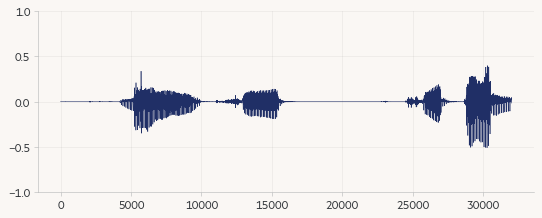

wave min/max -0.8366394 0.7415161


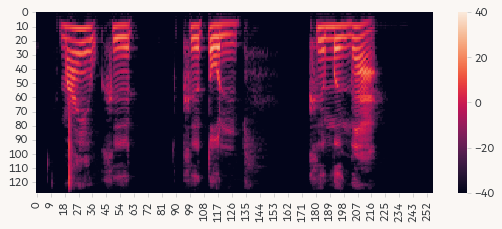

Melspec min/max -47.069035 32.930965


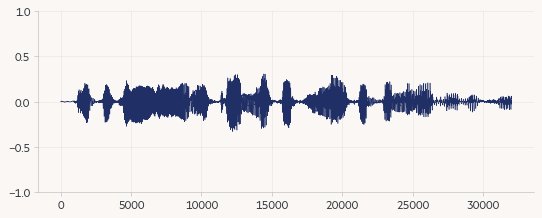

wave min/max -0.3692932 0.38885498


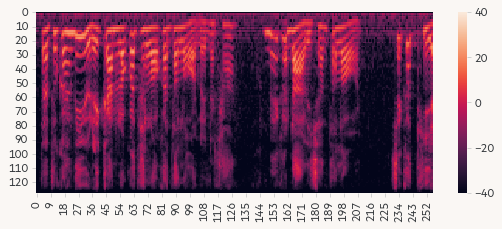

Melspec min/max -54.92482 25.075178


In [23]:
for f in df['path'].head(2):
    audio_tensor, mel_spec = prep.preprocess(f)
    plot_wave(audio_tensor)
    audio_tensor = audio_tensor.numpy()
    print("wave min/max", audio_tensor.min(), audio_tensor.max())
    plot_spec(mel_spec)
    mel_spec = mel_spec.numpy()
    print("Melspec min/max", mel_spec.min(), mel_spec.max())